## Load_data

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
data = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/ds.npy")
gt = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/gt.npy")
print(data.shape)
print(gt.shape)

(145, 145, 200)
(145, 145)


In [4]:
H = data.shape[0]
W = data.shape[1]
#归一化
scaler = StandardScaler()
voxel = scaler.fit_transform(data.reshape(-1, data.shape[-1]))
print(voxel.shape)
#PCA 
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(voxel)
print(principalComponents.shape)
fullDataX = principalComponents.reshape(H,W,30)
fullDataY = gt

(21025, 200)
(21025, 30)


In [5]:
import cv2
from skimage.util import view_as_windows
print(fullDataX.shape)
#(145,145,3) -> (208,208,3)
paddedDatax = cv2.copyMakeBorder(fullDataX, 16, 15, 16, 15, cv2.BORDER_REPLICATE)
print(paddedDatax.shape)
#(208,208,3) -> (145,145,1,64,64,3) 208-64+1=145 || 3-3+1=1
X_train = view_as_windows(paddedDatax, (32, 32, 30), step=1).reshape(-1,32,32,30)
#(145,145,1,64,64,3) -> (21025,64,64,3)
print(X_train.shape)
y_train = fullDataY.reshape(-1,)
print(y_train.shape)

(145, 145, 30)
(176, 176, 30)
(21025, 32, 32, 30)
(21025,)


## Model_define

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
import os 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Input, Dense, Reshape, Dropout
os.environ["TFF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorflow import keras
def define_discriminator(in_shape=(32,32,30), n_classes=17):
  model = Sequential()

  model.add(Conv2D(64, kernel_size=(4,4), strides=2, input_shape=in_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, kernel_size=(4,4), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Conv2D(256, kernel_size=(4,4), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Conv2D(512, kernel_size=(4,4), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.35))
  model.add(Conv2D(64, kernel_size=(4,4), strides=1, padding="same"))

  model.add(Flatten())
  # model.summary()

  img = Input(shape=in_shape)
  features = model(img) 
  #validity预测是否是真实图像，label预测所属的类
  #二分类：sigmoid 多分类：softmax
  validity = Dense(1, activation="sigmoid")(features)
  label = Dense(n_classes, activation="softmax")(features)
  model = Model(img, [validity, label])
  opt = Adam(lr=0.00005, beta_1=0.5)
  model.summary() 
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt,metrics=['accuracy'])
  return model
d = define_discriminator()

###############test################
x = tf.random.normal([1,32,32,30])
prob = d(x)
print(prob[0].shape,prob[1].shape)
print("该图为真实HSI的概率：{:.2f}%%".format(prob[0].numpy()[0][0]*100))
print("该图预测所属类：{}".format(tf.argmax(prob[1][0].numpy(),axis=-1)))
###################################

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 30)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          3312128     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            257         sequential[1][0]                 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 17)           4369        sequential[1][0]                 
Total params: 3,316,754
Trainable params: 3,314,962
Non-trainable params: 1,792
______________

In [7]:
from tensorflow.keras.layers import Conv2DTranspose, Activation, Embedding, multiply
def define_generator(latent_dim, n_classes=17): #latent_dim = 100
	model = Sequential(name="gan")

	model.add(Dense(2*2*512, activation="relu", input_dim=latent_dim))
	model.add(Reshape((2,2, 512)))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2DTranspose(512, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2DTranspose(256, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=2, padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(momentum=0.8))

	model.add(Conv2DTranspose(30, kernel_size=(4,4), strides=1, padding='same'))
	model.add(Activation("tanh"))
	# model.summary()

	noise = Input(shape=(latent_dim,))#100
	label = Input(shape=(1,), dtype='int32')
	label_embedding = Flatten()(Embedding(n_classes, latent_dim,name="Embedding")(label)) #embedding(17,100) 17映射到100 params:17*100=1700

	model_input = multiply([noise, label_embedding]) #100 multiply 100 = (100,)
	img = model(model_input)
	model.summary()
	return Model([noise, label], img)
 
g = define_generator(100)
###############test################
#test
z_noise = tf.random.normal([1,100])
z_label = tf.cast(np.random.randint(1,17,1),tf.int32)
x_hat = g([z_noise,z_label])
print("生成图像形状：",x_hat.numpy().shape)
###################################

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194816   
_________________________________________________________________
activation (Activation)      (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408 

In [8]:
np.random.seed(666)
tf.random.set_seed(666)
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)

discriminator.trainable = False
gan_output = discriminator(generator.output)
gan_model = Model(generator.input, gan_output)
opt = Adam(lr=0.0005, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 30)] 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256)          3312128     input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            257         sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 17)           4369        sequential_1[1][0]               
Total params: 3,316,754
Trainable params: 3,314,962
Non-trainable params: 1,792
____________

In [0]:
d_path = "/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/train_models/D_continue.h5"
gan_path = "/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/train_models/gan_continue.h5"
discriminator.load_weights(d_path)
gan_model.load_weights(gan_path)

In [0]:
from skimage.color import label2rgb
label_image = discriminator.predict( X_train )

label_image = np.array(label_image[1])
y = []
for t in label_image:
  y.append(np.argmax(t))
label_image = np.array(y).reshape(145,145)
image_label_overlay = label2rgb(label_image)

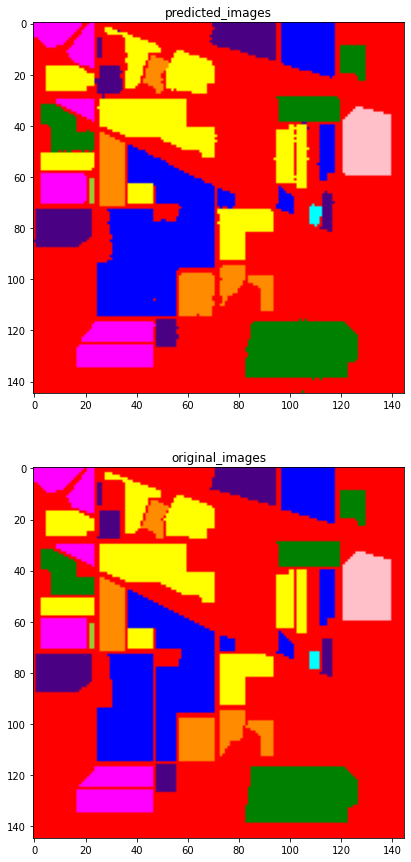

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2)  = plt.subplots(2,figsize=(15, 15))
ax1.set_title("predicted_images")
ax1.imshow(image_label_overlay)
image_label_overlay = label2rgb(fullDataY.reshape(145,145))
ax2.set_title("original_images")
ax2.imshow(image_label_overlay)


In [12]:
def define_gan(gan_model):
  gan = gan_model.get_layer("gan")
  embedding = gan_model.get_layer("Embedding")

  noise = Input(shape=(latent_dim,)) #(b,100)
  label = Input(shape=(1,),dtype="int32")
  
  label_embedding = Flatten()(embedding(label))
  model_input = multiply([noise,label_embedding])
  img = gan(model_input)
  g = Model(inputs=[noise,label], outputs=img)
  g.summary()
  return g
gan = define_gan(gan_model)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 100)       1700        input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 100)          0           Embedding[1][0]                  
____________________________________________________________________________________________

## Generate_data

In [17]:
generated_label = y_train[y_train>0]
print(generated_label)
print(generated_label.shape)

[ 3  3  3 ... 10 10 10]
(10249,)


In [0]:
generated_img = np.array([])
for i in range(52):
  if i == 51:
    index = slice(i*200,10249)
  else:
    index = slice(i*200, (i+1)*200)
  labels = generated_label[index]
  num = len(labels)
  z_noise = tf.random.normal([num,100])
  z_label = tf.cast(labels,tf.int32)

  imgs = gan([z_noise,z_label])

  if generated_img.shape == (0,):
    generated_img = imgs
  else:
    generated_img = np.concatenate((generated_img,imgs))


In [29]:
print(generated_img.shape)

(10249, 32, 32, 30)


In [0]:
width = 145
height = 145
PATCH_SIZE = 32
numComponents = 30
def Patch(data,height_index,width_index): #0-144 -> 32-176
  height_slice = slice(height_index, height_index+PATCH_SIZE)
  width_slice = slice(width_index, width_index+PATCH_SIZE)
  patch = data[height_slice, width_slice, :] 
  return patch

In [46]:
# calculate the predicted image
outputs = np.zeros((height,width))
num_indx = 0
for i in range(height):
    for j in range(width):
        target = fullDataY[int(i), int(j)]
        if target == 0 :
            continue
        else :
            # image_patch=Patch(paddedDatax,i,j)
            #print (image_patch.shape)
            # X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2]).astype('float32')
            X_test_image = generated_img[num_indx]   
            X_test_image = tf.reshape(X_test_image,(1,32,32,30))                                
            prediction = discriminator.predict(X_test_image)   
            prediction = tf.argmax(prediction[1], axis=-1).numpy()                     
            outputs[int(i)][int(j)] = prediction+1
            num_indx += 1
print(outputs.shape)

(145, 145)


In [47]:
!pip install spectral

     |████████████████████████████████| 194kB 2.8MB/s 


## Discriminator 检测生成的数据

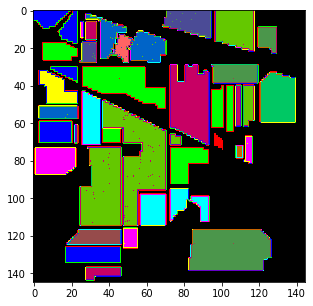

In [48]:
import spectral
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = fullDataY,figsize =(5,5))

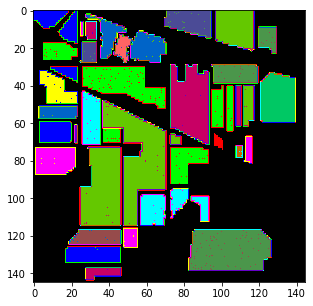

In [55]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int)-1,figsize =(5,5))
#注意discriminator最后在归类的时候是17类，其中非检测物体归为0类，也就是图中的黑色区域，为了和原图显示一致，因此要减一

## Discriminator检测原数据

In [50]:
# calculate the predicted image
outputs = np.zeros((height,width))
# num_indx = 0
for i in range(height):
    for j in range(width):
        target = fullDataY[int(i), int(j)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(paddedDatax,i,j)
            # print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2]).astype('float32')
            # X_test_image = generated_img[num_indx]   
            # X_test_image = tf.reshape(X_test_image,(1,32,32,30))                                
            prediction = discriminator.predict(X_test_image)   
            prediction = tf.argmax(prediction[1], axis=-1).numpy()                     
            outputs[int(i)][int(j)] = prediction+1
            # num_indx += 1
print(outputs.shape)

(145, 145)


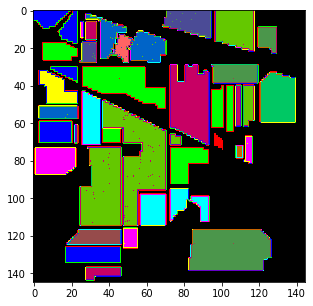

In [51]:
import spectral
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = fullDataY,figsize =(5,5))

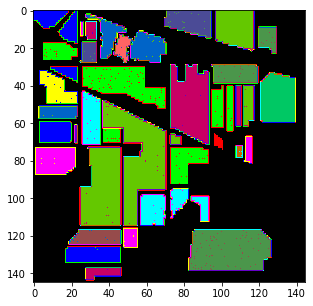

In [56]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int) - 1,figsize =(5,5))

## Conclusion:通过discriminator的检测，再通过生成的数据和原图数据比较，可以看出生成的图片淡绿色的区域并不是生成得很好，但是总体的质量还是可以的

In [59]:
print(generated_img.shape)
print(generated_label.shape)
generated_label = np.array(generated_label) #tuple->numppy
np.save("/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/New_data_generated_by_GAN/generated_data", generated_img)
np.save("/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/New_data_generated_by_GAN/generated_label", generated_label)

(10249, 32, 32, 30)
(10249,)


## 保存生成的数据，数据的labels和数量均与原数据近似，但是生成的data可能不一致